In [1]:
:e TupleSections
:e BlockArguments 

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Enumerator
import Control.Monad
import Control.Arrow
import Data.Bifunctor (bimap)
import Numeric.Log
import qualified Data.Text as T


:l ../plotting.hs

# Bayesian Models

Monad-Bayes exports a `Bayesian` datatype to make using Bayesian models easier. The idea is that you specify your model as a prior, generative model and a likelihood. 

```
data Bayesian m z o = Bayesian
  { prior :: m z,                      -- prior over latent variable Z; p(z)
    generative :: z -> m o,            -- distribution over observations given Z=z
    likelihood :: z -> o -> Log Double -- p(o|z)
  }
```

Likelihood is the PDF of the generative model and is a function from the problem domain to positive real numbers. Generative model allows for drawing samples from the distribution.
Likelihood and generative model are separated because you can't always get the density from a distribution definition.


Once you've defined Bayesian model, a number of standard operations, like obtaining the posterior or the posterior predictive, are automated for you.

Here's a simple example:

In [2]:
model :: MonadDistribution m => Bayesian m Bool Double
model = Bayesian {
    prior = bernoulli 0.5,
    generative = \x -> normal (if x then 2 else (-2)) 1,
    likelihood  = \x y -> normalPdf (if x then 2 else (-2)) 1 y
    }

## Prior

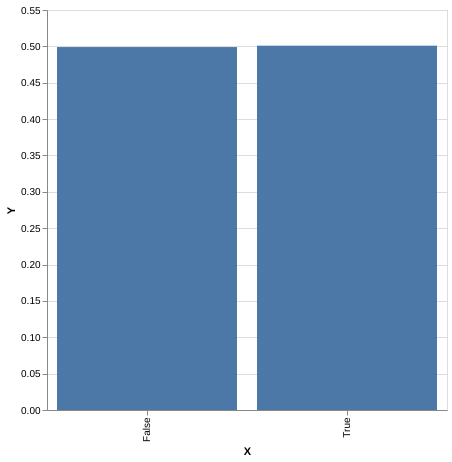

In [3]:
sampler $ 
    plot . fmap (first (T.pack . show)) . toEmpirical <$> 
    replicateM 100000 (prior model)

## Prior predictive

Prior predictive model is an application of the generative distribution to the prior distribution.

Similarly as in `Sampling.ipynb` example we need to introduce a constant weight by mapping samples to a pair (value, score) with `(,constWeight) <$> `.

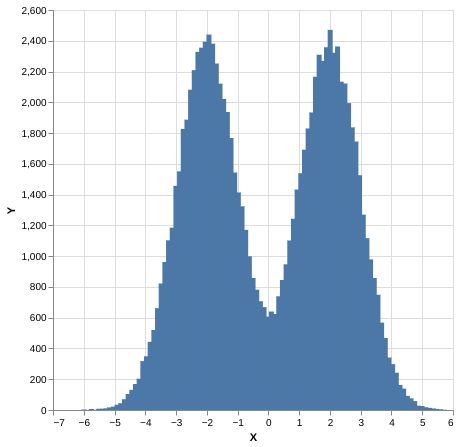

In [4]:
constWeight = 1 :: Log Double

sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 ((,constWeight) <$>  priorPredictive model)

## Posterior

Posterior distribution is computed using `likelihood` and observations $os = \{o_{1}, \dots o_{n} \}$.
Factors are computed for posterior for `model`, and in the considered example yield following: 
- $ \prod_{i=1}^{n} \text{likelihood}(\text{True}, o_{i}) $ for `True` 
- $ \prod_{i=1}^{n} \text{likelihood}(\text{False}, o_{i}) $ for `False`.

Note that factors do not have to sum up to 1. Empirical distribution is obtained by normalizing factors to 1.


### Observations

In our example, we experiment how observed data change the a priori model given the likelihood function. Observations should be in the domain of the likelihood function.

Taking symmetrical and evenly distributed points, we do not change the posterior distribution:

In [5]:
observations1 = [-3..3]
sampler $ toEmpiricalWeighted <$> replicateM 100000 (weighted $ posterior model observations1)

[(True,0.5005199999999994),(False,0.49948000000000126)]

On the other hand, if the observations are unevenly distributed adjustments to posterior are well visible:

In [6]:
observations2 = [-2.3, -2, 0, 0.3, 2, 2.3]
sampler $ toEmpiricalWeighted <$> replicateM 100000 (weighted $ posterior model observations2)

[(True,0.7669770523099223),(False,0.23302294769007775)]

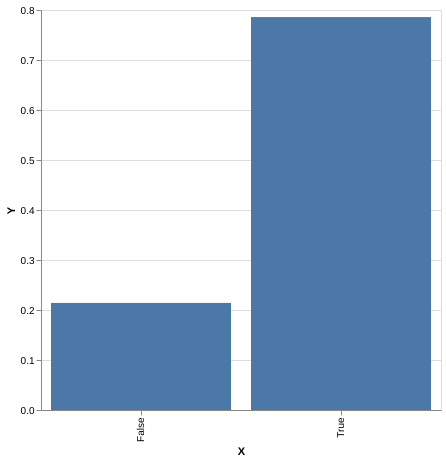

In [7]:
sampler $ 
    plot . fmap (bimap (T.pack . show) (ln . exp)) . toEmpiricalWeighted <$> 
    replicateM 1000 (weighted $ posterior model observations2)

### Excercise

Change the observations lists and see how the posterior is affected.
Change standard deviation of `likelihood` and see how posterior changes.


## Posterior predictive

Analoguosly to prior predictive is generated by `generative` applied to `posterior`.

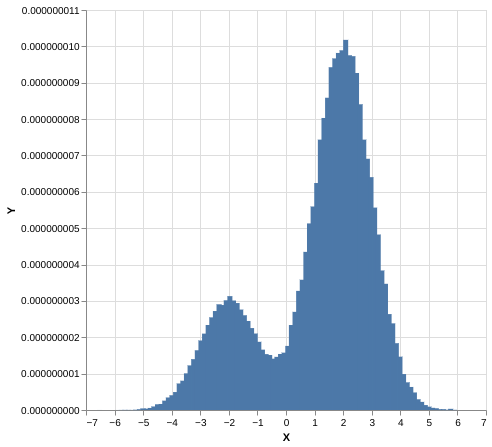

In [8]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 (weighted $ posteriorPredictive model observations2)

# Regression

The classical example of linear regression:

In [9]:
range :: [Double]
range = [-10,-9.9..10] 


regression :: MonadDistribution m => Bayesian m (Double, Double, Double) [Double]
regression = Bayesian {
    prior = do 
            slope <- normal 0 2
            intercept <- normal 0 2
            noise <- gamma 4 4
            return (slope, intercept, noise),
    
    generative = \(slope, intercept, noise) -> do
            forM range \x -> normal (x*slope + intercept) (sqrt noise),
            
    likelihood = \(slope, intercept, noise) ys -> Prelude.sum [normalPdf (x*slope + intercept) (sqrt noise) y | (x,y) <- zip range ys] 
                
    }


## Prior predictive

`prior` distribution has three independent parameters. `generative` combines them into a new distribution.

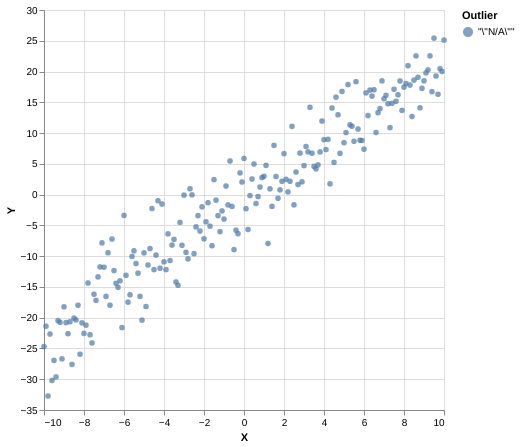

In [10]:
ys <- sampler $ priorPredictive regression

plot (fmap (second (T.pack . show)) (zip (zip range ys) (Prelude.repeat "N/A")))

## Posterior predictive

`posterior` distribution is computed base on the observed samples. Let's see what happens if the model sees samples of the same value only.

To explore the space of possible parameters we use Monte Carlo Markov Chain inference algorithm.

In [11]:
import Control.Monad.Bayes.Inference.MCMC

observations = [replicate 100 1]

ys <- sampleIOfixed $ mcmc MCMCConfig {numMCMCSteps = 5000, numBurnIn = 300, proposal = SingleSiteMH} 
    $ posteriorPredictive regression observations


`ys` is a **list of lists** containing values generated for arguments from `range`. Let's see how an example of generated samples look like:

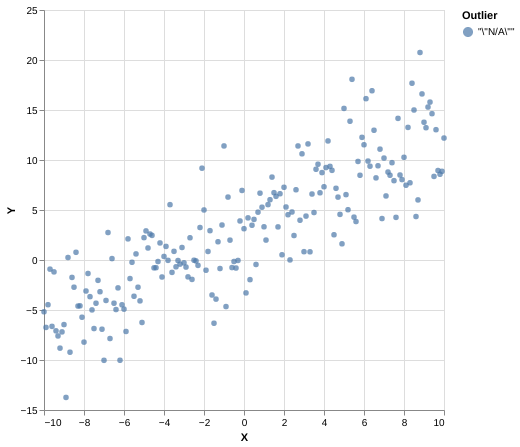

In [12]:
plot (fmap (second (T.pack . show)) (zip (zip range $ head ys) (Prelude.repeat "N/A")))

Given the observations, we expect the model have average value of `slope` to be 0 and `intercept` 1.

In [13]:
avg l = Prelude.sum l / fromIntegral (length l)

avX   = avg range
avSqr = Prelude.sum $ map (\a -> (a-avX)**2) range

In [14]:
slopeValue l = covXY / avSqr
  where
    avY   = avg l
    covXY = Prelude.sum $ (\(x,y) -> (x - avX) * (y - avY)) <$> zip range l
    
interceptValue l = avg l - slopeValue l * avX

In [15]:
nObservations = length $ head observations

print $ "Average slope for " <> show nObservations <> " observations: " <> (show . avg $ slopeValue <$> ys)

print $ "Average intercept for " <> show nObservations <> " observations: " <> (show . avg $ interceptValue <$> ys)

"Average slope for 100 observations: 0.6482984353867459"

"Average intercept for 100 observations: 1.2220350681014394"

Slope and intercept average values differ a bit from the expected 0 and 1. Let's how they behave given more observations of the same kind.

In [16]:
observations1 = [replicate 200 1]

ys1 <- sampleIOfixed $ mcmc MCMCConfig {numMCMCSteps = 5000, numBurnIn = 300, proposal = SingleSiteMH} 
    $ posteriorPredictive regression observations1


In [17]:
nObservations = length $ head observations1

print $ "Average slope for " <> show nObservations <> " observations: " <> (show . avg $ slopeValue <$> ys1)
print $ "Average intercept for " <> show nObservations <> " observations: " <> (show . avg $ interceptValue <$> ys1)

"Average slope for 200 observations: 0.20039201335018098"

"Average intercept for 200 observations: 1.1534663432408423"

### Excercise

To better understand how the Bayesian model works here, you may do following:
1. play with prior: change it to be constant, randomize `noise` only
2. play with observations: empirically check the limit where new observations change posterior insignificantly given the inference parameters
3. change inference paramers.